In [1]:
pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 72 kB/s 


In [36]:
import tensorflow as tf
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from sklearn.tree import DecisionTreeRegressor,ExtraTreeRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import TimeSeriesSplit,RandomizedSearchCV
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import SelectKBest, r_regression
from sklearn.metrics import r2_score,mean_absolute_error,mean_squared_error,mean_absolute_percentage_error
pd.options.display.float_format = '{:.4f}'.format

Los datos, son los valores mensuales de la serie de uno de los índices más importantes de la bolsa de valores de New York,el índice Nasdaq Composite y tenemos la información de su valor a la apertura del mercado y al cierre del mismo

In [3]:
ixc=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Procesamiento_y_Clasificacion_de_Datos/Tarea_3/^IXIC.csv')

Los datos son los históricos de la serie 

In [4]:
ixc.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-01,5874.859863,5928.060059,5769.390137,5911.740234,5911.740234,43937720000
1,2017-04-01,5917.319824,6074.040039,5805.149902,6047.609863,6047.609863,33793200000
2,2017-05-01,6067.560059,6221.990234,5996.810059,6198.520020,6198.520020,42285390000
3,2017-06-01,6215.910156,6341.700195,6087.810059,6140.419922,6140.419922,48689910000
4,2017-07-01,6173.290039,6460.839844,6081.959961,6348.120117,6348.120117,36063120000


**Gráfica de la serie**

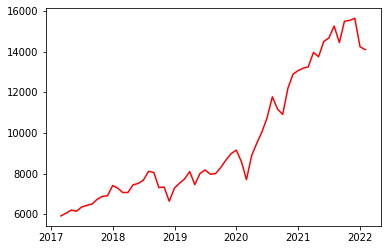

In [33]:
plt.plot(ixc["Close"],color="red")

Quitamos el último dato que representa el 4 de febrero de 2022 en lugar de una medición mensual como los demás registros

In [6]:
ixc=ixc[['Date','Close']].drop(index=[ixc.index.max()])

In [7]:
ixc.shape

(60, 2)

In [8]:
ixc['Date']=pd.to_datetime(ixc['Date'])  
ixc.set_index(['Date'],inplace=True)

Creamos los lags de las variables, en nuestro caso inicia en 1 porque queremos predicir el siguiente mes, si queremos pronosticar con un mayor rango basta con cambiar este parámetrommm

In [9]:
for i in range(1,13):
  ixc[f'Close_{i}']=ixc['Close'].shift(i)

Eliminamos los registros imcompletos

In [11]:
tad=ixc.dropna()

In [12]:
X=tad.drop(columns=['Close'])
y=tad[['Close']]

## Explosión de variables

Una de las técnicas más utiles para la explosición de variables es utilizar una generación de polinomios de orden n con las variables que ya tenemos actualmente, para este caso generaremos hasta polinomios de orden 3.

In [15]:
%%time
poly = PolynomialFeatures(3)
X=poly.fit_transform(X)

CPU times: user 6.69 ms, sys: 0 ns, total: 6.69 ms
Wall time: 7.05 ms


Con esta técnica generamos 443 variables, entones pasamos de tener 12 variables a tener 455

In [21]:
pd.DataFrame(X,columns=poly.get_feature_names_out()).head(2)

,1,Close_1,Close_2,Close_3,Close_4,Close_5,Close_6,Close_7,Close_8,Close_9,...,Close_10^3,Close_10^2 Close_11,Close_10^2 Close_12,Close_10 Close_11^2,Close_10 Close_11 Close_12,Close_10 Close_12^2,Close_11^3,Close_11^2 Close_12,Close_11 Close_12^2,Close_12^3
0,1.0,7273.009766,7411.479980,6903.390137,6873.970215,6727.669922,6495.959961,6428.660156,6348.120117,6140.419922,...,2.381574e+11,2.323592e+11,2.271388e+11,2.267021e+11,2.216089e+11,2.166300e+11,2.211828e+11,2.162135e+11,2.113559e+11,2.066075e+11
1,1.0,7063.450195,7273.009766,7411.479980,6903.390137,6873.970215,6727.669922,6495.959961,6428.660156,6348.120117,...,2.315230e+11,2.337137e+11,2.280237e+11,2.359251e+11,2.301812e+11,2.245772e+11,2.381574e+11,2.323592e+11,2.267021e+11,2.211828e+11


In [23]:
X=pd.DataFrame(X,index=tad.index)

## Selección de mejores variables

In [49]:
k_best = SelectKBest(score_func=r_regression, k=20)
X=k_best.fit_transform(X,y)
X=pd.DataFrame(X,index=tad.index)
k_best.get_feature_names_out()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/feature_selection/_univariate_selection.py:289: RuntimeWarning: divide by zero encountered in true_divide
  correlation_coefficient /= X_norms


array(['x1', 'x2', 'x3', 'x4', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18',
       'x19', 'x20', 'x25', 'x26', 'x27', 'x91', 'x92', 'x93', 'x94',
       'x103'], dtype=object)

Calculamos el corte para nuestro train test split

In [26]:
X.shape[0]*0.7

33.599999999999994

In [27]:
X.index.min()

Timestamp('2018-03-01 00:00:00')

In [50]:
X_tr=X['2018-03-01':'2021-03-01']
X_ts=X['2021-04-01':]
y_tr=y['2018-03-01':'2021-03-01']
y_ts=y['2021-04-01':]

## Modelos de aprendizaje supervisado

In [40]:
dt_r_param_grid={'max_depth': [1,2,3,4,5,6],
    "min_samples_split": [2,5,7],
    "min_samples_leaf": [1,2,5]}
et_r_param_grid={'max_depth': [1,2,3,4,5,6],
    "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]}
xgb_r_param_grid={'max_depth': [1,2,3,4,5,6],
              'learning_rate': [0.01,0.05, 0.1, 0.2, 0.3, 0.4],
              'n_estimators': [100, 250, 500],
              'subsample':[0.5]}
rf_r_param_grid={'max_depth': [1,2,3,4,5,6],
              'n_estimators': [100, 250, 500],
              "min_samples_split": [2,5,7,10],
    "min_samples_leaf": [1,2,5]
    }
cb_r_param_grid={    
    'learning_rate': [0.001,0.01,0.03,0.05,0.07,0.1],
    'iterations': [10, 20,30,40,50,60,70,80,90,100,200,300],
    'depth':  [1,2,3,4,5,6]
    }


In [52]:
%%time
model1=DecisionTreeRegressor()
model2=ExtraTreeRegressor()
model3=XGBRegressor()
model4=RandomForestRegressor()
model5=CatBoostRegressor(silent=True)
rs_dt=RandomizedSearchCV(model1, param_distributions=dt_r_param_grid, cv=4, error_score=-1000, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1, refit=True)
rs_et=RandomizedSearchCV(model2, param_distributions=et_r_param_grid, cv=4, error_score=-1000, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1, refit=True)
rs_xgb=RandomizedSearchCV(model3, param_distributions=xgb_r_param_grid, cv=4, error_score=-1000, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1, refit=True)
rs_rf=RandomizedSearchCV(model4, param_distributions=rf_r_param_grid, cv=4, error_score=-1000, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1, refit=True)
rs_catb=RandomizedSearchCV(model5, param_distributions=cb_r_param_grid, cv=4, error_score=-1000, n_jobs=-1, scoring='neg_root_mean_squared_error', verbose=1, refit=True)
rs_dt.fit(X_tr,y_tr)
rs_et.fit(X_tr,y_tr)
rs_xgb.fit(X_tr,y_tr)
rs_rf.fit(X_tr,y_tr)
rs_catb.fit(X_tr,y_tr)

Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
Fitting 4 folds for each of 10 candidates, totalling 40 fits
[20:07:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Fitting 4 folds for each of 10 candidates, totalling 40 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


Fitting 4 folds for each of 10 candidates, totalling 40 fits
CPU times: user 1.69 s, sys: 76.8 ms, total: 1.76 s
Wall time: 19.5 s


## Resultados

In [53]:
ls_models=[rs_dt,rs_et,rs_xgb,rs_rf,rs_catb]
dic_res={'Modelo':['DecisionTree','ExtraTree','XGBoosting','RandomForest','CatBoosting'],
         'R2_tr':[],
         'R2_ts':[],
         'MSE_tr':[],
         'MSE_ts':[],
         'MAE_tr':[],
         'MAE_ts':[],
         'MAPE_tr':[],
         'MAPE_ts':[]}

In [54]:
for mod in ls_models:
  dic_res['R2_tr'].append(r2_score(y_tr,mod.predict(X_tr)))
  dic_res['R2_ts'].append(r2_score(y_ts,mod.predict(X_ts)))
  dic_res['MSE_tr'].append(mean_squared_error(y_tr,mod.predict(X_tr)))
  dic_res['MSE_ts'].append(mean_squared_error(y_ts,mod.predict(X_ts)))
  dic_res['MAE_tr'].append(mean_absolute_error(y_tr,mod.predict(X_tr)))
  dic_res['MAE_ts'].append(mean_absolute_error(y_ts,mod.predict(X_ts)))
  dic_res['MAPE_tr'].append(mean_absolute_percentage_error(y_tr,mod.predict(X_tr)))
  dic_res['MAPE_ts'].append(mean_absolute_percentage_error(y_ts,mod.predict(X_ts)))

In [55]:
pd.DataFrame(dic_res)

,Modelo,R2_tr,R2_ts,MSE_tr,MSE_ts,MAE_tr,MAE_ts,MAPE_tr,MAPE_ts
0,DecisionTree,0.9755,-5.4593,93306.2990,2741829.2733,258.7149,1522.2854,0.0304,0.1019
1,ExtraTree,0.9774,-5.9761,86334.8218,2961194.7079,240.9907,1592.7078,0.0275,0.1067
2,XGBoosting,1.0000,-4.7448,19.5963,2438539.5722,2.7467,1418.8858,0.0003,0.0948
3,RandomForest,0.9865,-5.8548,51320.4813,2909714.3456,190.0283,1576.4270,0.0218,0.1056
4,CatBoosting,0.9621,-9.7440,144648.7230,4560572.2898,318.1482,2033.7394,0.0361,0.1367


In [ ]:
def DescomponerSerie(serie,longitud):
    global X, y
    X, y=list(), list()
    for i in range(len(serie)):
        final=i+longitud
        if final > len(serie)-1:
            break
        historia_x, target_y=serie[i:final], serie[final]
        X.append(historia_x)
        y.append(target_y)
    return np.array(X), np.array(y)

In [ ]:
Close = list(ixc["Close"])

Selecciono 12 meses porque regularmente las estacionalidades se alcanzan a marcar mejor durante todos la revisión de todo el periodo de un año completo es decir Year to Date

In [ ]:
DescomponerSerie(Close,12)

(array([[ 5911.740234,  6047.609863,  6198.52002 ,  6140.419922,
          6348.120117,  6428.660156,  6495.959961,  6727.669922,
          6873.970215,  6903.390137,  7411.47998 ,  7273.009766],
        [ 6047.609863,  6198.52002 ,  6140.419922,  6348.120117,
          6428.660156,  6495.959961,  6727.669922,  6873.970215,
          6903.390137,  7411.47998 ,  7273.009766,  7063.450195],
        [ 6198.52002 ,  6140.419922,  6348.120117,  6428.660156,
          6495.959961,  6727.669922,  6873.970215,  6903.390137,
          7411.47998 ,  7273.009766,  7063.450195,  7066.27002 ],
        [ 6140.419922,  6348.120117,  6428.660156,  6495.959961,
          6727.669922,  6873.970215,  6903.390137,  7411.47998 ,
          7273.009766,  7063.450195,  7066.27002 ,  7442.120117],
        [ 6348.120117,  6428.660156,  6495.959961,  6727.669922,
          6873.970215,  6903.390137,  7411.47998 ,  7273.009766,
          7063.450195,  7066.27002 ,  7442.120117,  7510.299805],
        [ 6428.66015

Se seleccionaran las neuronas de la capa oculta con base a la fórmula que da mejores resultados en el artículo de Sheela.
$$hidden\ neurons=\frac{4n^{2}+3}{n^{2}-8}$$
Sheela, G. K. (2013, 20 junio). Review on Methods to Fix Number of Hidden Neurons in Neural Networks. Hindawi. https://www.hindawi.com/journals/mpe/2013/425740/

$$hidden\ neurons=\frac{4n^{2}+3}{n^{2}-8}=\frac{4(12)^{2}+3}{(12)^{2}-8}=4.2573\approx4$$

In [ ]:
n=12
OHL=(4*(n**2)+3)/((n**2)-8)
print(OHL)

4.257352941176471


In [61]:
model = Sequential()
model.add(Dense(4, activation='relu', input_dim=20))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adamax', metrics=['MeanSquaredError','MeanAbsolutePercentageError','MeanAbsoluteError'])

In [65]:
%%time
model.fit(np.array(X_tr), np.array(y_tr), epochs=1000, batch_size=4)

Epoch 1/1000
10/10 [==============================] - 0s 2ms/step - loss: 1130742980685070336.0000 - mean_squared_error: 1130742980685070336.0000 - mean_absolute_percentage_error: 3201927.2500 - mean_absolute_error: 261996896.0000
Epoch 2/1000
10/10 [==============================] - 0s 3ms/step - loss: 1098616075555176448.0000 - mean_squared_error: 1098616075555176448.0000 - mean_absolute_percentage_error: 3151834.0000 - mean_absolute_error: 257956720.0000
Epoch 3/1000
10/10 [==============================] - 0s 2ms/step - loss: 1071530431238635520.0000 - mean_squared_error: 1071530431238635520.0000 - mean_absolute_percentage_error: 3101859.5000 - mean_absolute_error: 254015072.0000
Epoch 4/1000
10/10 [==============================] - 0s 3ms/step - loss: 1041756274833752064.0000 - mean_squared_error: 1041756274833752064.0000 - mean_absolute_percentage_error: 3050929.2500 - mean_absolute_error: 249945696.0000
Epoch 5/1000
10/10 [==============================] - 0s 2ms/step - loss: 10

In [68]:
dic_res['Modelo'].append('Neural Netwoork')
dic_res['R2_tr'].append(r2_score(y_tr,model.predict(np.array(X_tr))))
dic_res['R2_ts'].append(r2_score(y_ts,model.predict(np.array(X_ts))))
dic_res['MSE_tr'].append(mean_squared_error(y_tr,model.predict(np.array(X_tr))))
dic_res['MSE_ts'].append(mean_squared_error(y_ts,model.predict(np.array(X_ts))))
dic_res['MAE_tr'].append(mean_absolute_error(y_tr,model.predict(np.array(X_tr))))
dic_res['MAE_ts'].append(mean_absolute_error(y_ts,model.predict(np.array(X_ts))))
dic_res['MAPE_tr'].append(mean_absolute_percentage_error(y_tr,model.predict(np.array(X_tr))))
dic_res['MAPE_ts'].append(mean_absolute_percentage_error(y_ts,model.predict(np.array(X_ts))))

In [70]:
pd.DataFrame(dic_res).to_csv('/content/drive/MyDrive/Colab Notebooks/Procesamiento_y_Clasificacion_de_Datos/Tarea_3/Resultados.csv',index=False)